Name: Christian Hellum Bye \
E-mail: chbye@berkeley.edu \
Date: 4/12/22

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

In [25]:
DATA_FILE = "location_data_hw8_2022.csv"
with open(DATA_FILE) as f: header = f.readline(); print(header)
data = np.loadtxt(DATA_FILE, skiprows=1, delimiter=",")

t,red_pos_X,red_pos_Y,blue_pos_X,blue_pos_Y



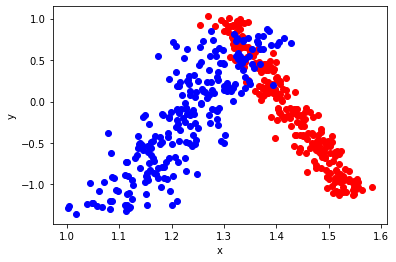

In [27]:
plt.figure()
for i, color in enumerate(["red", "blue"]):
    x_idx = 2 * i + 1
    y_idx = x_idx + 1
    x = data[:, x_idx]
    y = data[:, y_idx]
    plt.scatter(x, y, c=color)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

We don't know what units these measurements are in, so for ease of notation we will assume the lenght units are meters [m] and the time units are seconds [s]. The unit of speed is thus m/s. We note that the choice of units are arbitrary.

In [37]:
print("Total time of motion is {:.2f}s.".format(data[:, 0].max() - data[:, 0].min()))

Total time of motion is 942.10s.


The objects are moving across a range of order $\Delta l \sim 1$m in a time of $\Delta t \approx 1000$s. This indicates that the speed of the objects should be of order $v \sim 10^{-3}$m/s.

Since we assume the velocity of each object is constant in magnitude and direction, we can in principle measure the velocity at time step $i$ by computing 
$$\frac{x_{i+1}-x_{i}}{t_{i+1}-t_{i}}$$.

We convert the position measurements to a set of time measurements:

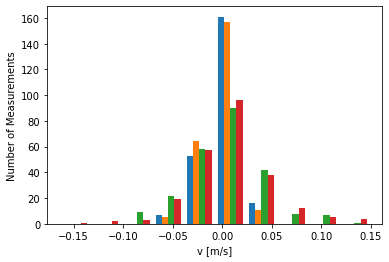

In [51]:
dt = np.diff(data[:, 0])  # delta times
v_rx = np.diff(data[:, 1])/dt  # red object, x-direction
v_ry = np.diff(data[:, 2])/dt  # red object, y-direction
v_bx = np.diff(data[:, 3])/dt  # blue object, x-direction
v_by = np.diff(data[:, 4])/dt  # blue object, y-direction

v_data = np.array([v_rx, v_ry, v_bx, v_by])

plt.figure()
plt.hist([v_rx, v_ry, v_bx, v_by])
plt.xlabel("v [m/s]")
plt.ylabel("Number of Measurements")
plt.show()

The likelihood distribution of the velocities is certainly a Gaussian distribution since the position data has Gaussian random noise and the speed is computed from two position measurements $x_1$, $x_2$ by $v=\frac{x_2-x_1}{\Delta t}$. The noise is independent and identically distributed the variance of the Gaussians are the same for the four unknown quantities ($v_x$ and $v_y$ for both objects). However, there is no reasons for the means of the distributions to be the same. As the noise is unknown, we sample the variance of the likelihood distribution, $\sigma^2$ from a uniform distribution of values 0-0.05 $\rm{(m/s)}^2$.

For the prior, we don't have much information about the velocities or much physical intuition about the system. We therefore pick uniform priors across the range $-0.2 - +0.2$ m/s for each velocity component, which is a wide range that spans all of the measured velocities.

In [60]:
# bounds on prior velocity dist (m/s)
V_LO = -.2
V_HI = .2


with pm.Model() as model:
    mu = pm.Uniform('mu', V_LO, V_HI)  # prior
    var = pm.Uniform("var", 0, 0.05)
    data = pm.Data('data', v_data[0])
    X = pm.Normal('X', mu=mu, sigma=np.sqrt(var), observed=data)
    
traces = []
for v_obs in v_data:
    with model:
        # Switch out the observed dataset
        pm.set_data({'data': v_obs})
        step = pm.NUTS()
        trace = pm.sample(20000, step=[step], cores=2, return_inferencedata=False)
        traces.append(trace)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [var, mu]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 6 seconds.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [var, mu]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 6 seconds.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [var, mu]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 7 seconds.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [var, mu]


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 8 seconds.


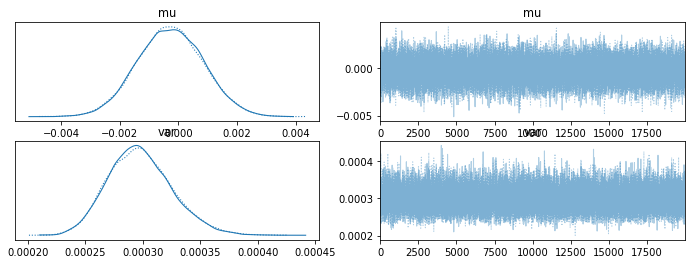

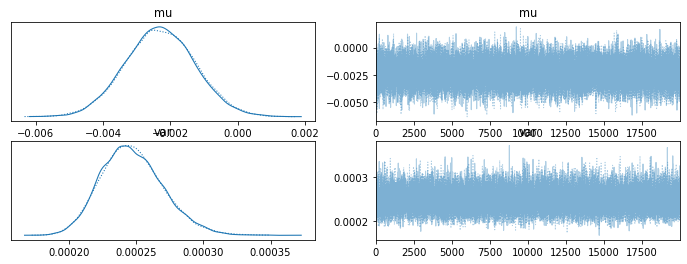

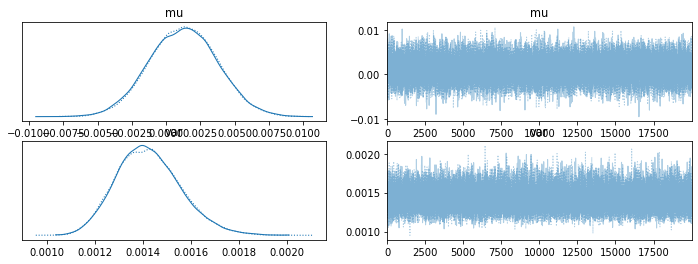

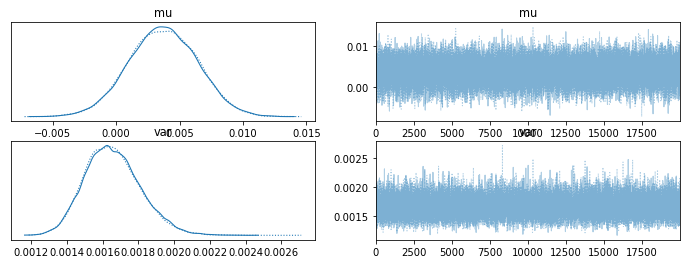

In [61]:
import arviz as az
with model:
    for trace in traces:
        _ = az.plot_trace(trace)